# Structural estimation

**Table of contents**<a id='toc0_'></a>    
- 1. [Model](#toc1_)    
- 2. [Simulated Minimum Distance](#toc2_)    
- 3. [Estimating our model](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


* The great **benefit** of such a model is that it can be used to run **counter factual scenarios** based on economic policy.
* But then we need the model to be **empirically relevant**!
* When we solved it, we just plugged in some parameters that seemed reasonable.
* That is not good enough for proper policy guidance.
* We need to estimate the core parameters from data.
* This is called **structural estimation**. 
* Structural estimation means that you impose behavioral structure (given by the model) on your data to get statistical predictions.
* In our current example, we impose that people are forward looking, optimizing and derive utility from choices in a certain way. 

In [1]:
%load_ext autoreload
%autoreload 2

from types import SimpleNamespace
from copy import deepcopy

import numpy as np
from scipy import optimize

import ConsumptionSaving as cs
# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Model](#toc0_)

A household lives for 2 periods and makes decisions on consumption and saving in each period.  

**Second period:**

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

**First period:**

$$
\begin{aligned}
v_1(m_1)&=\max_{c_1}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
a_1&=m_1-c_1\\
m_2&= (1+r)(m_1-c_1)+y_2 \\
y_{2}&= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
a_1&\geq0
\end{aligned}
$$

<font size="5">How are the parameters of such a model estimated?</font>

* We can use **Simulated Minimum Distance** (SMD), aka Simulated Method of Moments, aka matching on moments. 
* Yes, it is closely related to GMM.
* It is a Swiss-army knife of structural estimation, generally available. 
* Word on the street: *"if you can simulate it, you can estimate it"*
* Other structural models may be estimated by maximum likelihood (preferable when possible). 
* Today, we will only look at parameters estimates to get the intuition right. 
* Standard errors are for another day, see [here](https://github.com/NumEconCopenhagen/ConsumptionSavingNotebooks/blob/master/00.%20DynamicProgramming/04.%20Structural%20Estimation.ipynb) if you are interested. 

## 2. <a id='toc2_'></a>[Simulated Minimum Distance](#toc0_)

**Outline**   
1. Define the set of parameters to be estimated, denoted $\theta$. <br>We set $\theta = \{\rho\}$, the risk aversion. 
2. Define a set of moments from data that can identify $\theta$. (The tricksy part)
3. We will use 3 moments: mean consumption in period 1 and 2, and mean variance in consumption across periods.
4. These moments are calculated from an empirical data set.
5. We then simulate the model with trial values of $\rho$ until the moments from the simulated data is close to the empirical moments. 

**Definitions**

* We have individual observations on $N^d$ individuals over $T^d$ periods, denoted $w_i$.
* We assume that the empirical  data is generated by our model which is parameterized by $\theta_{dgp}$
* We define a moment generating function: 
    * $\Lambda = \frac{1}{N}\sum_{i=1}^N m(\theta|w_i)$
* As noted $\Lambda$, holds the mean of $c_1$, mean of $c_2$ and mean of $\text{var}(c_1,c_2)$
* Thus, the moments from data is given by 
    * $\Lambda_{data} = \frac{1}{N^d}\sum_{i=1}^{N^d} m(\theta_{dgp}|w_i)$
* Given the *guess* $\theta$ on the data generating parameter $\theta_{dgp}$, we can simulate the same set of moments from the model.
* Therefore, we simulate $N^s$ individuals over $T^s$ periods, and the outcome observation is denoted $w_s$
* The simulated set of moments are given by 
    * $\Lambda_{sim}(\theta) = \frac{1}{N_{sim}}\sum_{s=1}^{N_{sim}} m(\theta|w_s)$ 
* Finally, we define the function $g(\theta)$, which is the difference between data moments and simulation moments:
    * $g(\theta)=\Lambda_{data}-\Lambda_{sim}(\theta)$

**Simulated Minimum Distance (SMD)** estimator is then given by

$$
\hat{\theta} = \arg\min_{\theta} g(\theta)'Wg(\theta)
$$

where $W$ is a **weighting matrix**. $W$ is $J \times J$, where $J$ is the number of moments. The relative size of elements in $W$ determines the importance of the corresponding moments.   
One can derive an optimal $W$, but in practice, the Identity matrix often works well. So in our case:
$$ 
\begin{aligned}
W = 
\begin{bmatrix} 
1 & 0 & 0 \\ 
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix} 
\end{aligned}
$$


## 3. <a id='toc3_'></a>[Estimating our model](#toc0_)

Based on a set of "true" parameters we simulate the model for $N^d$ individuals. The outcome is our "empirical" data set. We therefore know exactly what our estimation should lead to.

In [2]:
par_dgp = SimpleNamespace()
par_dgp.rho = 8
par_dgp.kappa = 0.5
par_dgp.nu = 0.1
par_dgp.r = 0.04
par_dgp.beta = 0.94
par_dgp.Delta = 0.5

Create a model object based on true parameters and solve it:

In [3]:
true_model = cs.ConsumptionSavingModel(par_dgp)
m1,c1,m2,c2 = true_model.solve()

Visualize the solution just to be sure that it looks right

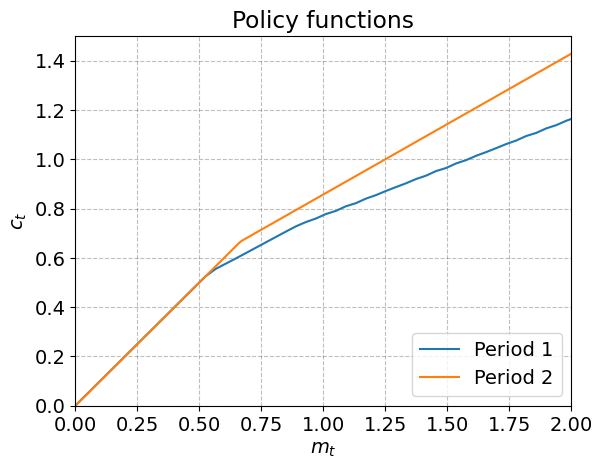

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1,c1, label=f'Period {1}')
ax.plot(m2,c2, label=f'Period {2}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$')
ax.set_title('Policy functions')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5]);

Based on the solution, we can create a distribution of initial cash-on-hand, $m_1$, and simulate the following consumption savings paths 

In [5]:
# Simulate a data set based on the true model
simN = 100_000
true_model.sim_m1 = np.fmax(np.random.normal(1,0.1,size=simN), 0) #np.fmax: One cannot have negative m
data_c1, data_c2 = true_model.simulate() # Simulate choices based on initial m

We also need to set up a model for estimation.   
We want to estimate $\rho$. This info is provided as an attribute to the model.

In [6]:
# Create model object for estimation
par = deepcopy(par_dgp)
est_model = cs.ConsumptionSavingModel(par)

est_model.theta_name = 'rho'
est_model.sim_m1 = np.fmax(np.random.normal(1,0.1,size=simN),0)

The function $\Lambda = \frac{1}{N}\sum_{i=1}^N m(\theta|w_i)$ is called `moment_func()`

In [7]:
def moment_func(c1, c2):
    mom1 = c1.mean()
    mom2 = c2.mean()
    mom3 = np.var(np.stack((c1, c2)), axis=0).mean() # Averaging the variance of [c_1, c_2] over individuals
    return np.array([mom1, mom2, mom3])

The function $g(\theta)=\Lambda_{data}-\Lambda_{sim}(\theta)$ is called `moments_diff()`

In [8]:
def moments_diff(model, data_moms):
    sim_c1, sim_c2 = model.simulate() # sim_c1 and sim_c2 are arrays 
    sim_moms = moment_func(sim_c1, sim_c2) 
    return sim_moms - data_moms 

Our objective $g(\theta)'Wg(\theta)$ is in the function `obj_func()` 

In [9]:
def obj_func(theta, model, data_moms, W):
    setattr(model.par, model.theta_name, theta)
    diff = moments_diff(model, data_moms)
    obj = diff @ W @ diff
    return obj

We can now calculate data moments, $\Lambda_{data}$ and define $W$

In [10]:
data_moms = moment_func(data_c1, data_c2)
W = np.eye(len(data_moms))

print('Data moments\n', data_moms)
print('Weighting matrix\n',W)

Data moments
 [0.77123589 0.9918077  0.03268197]
Weighting matrix
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


We are now ready to estimate!   

**The estimation algorithm is as follows:**
1. Calculate data moments, define $W$ and initial guess at estimated parameter $\theta = \theta^{guess}_0$. Set stopping threshold $\epsilon > 0$.  
2. Solve the model.
3. Simulate moments from the solution.
4. Calculate the objective based on simulated moments.
5. Make a new guess $\theta^{guess}_1$ 
6. Perform 2.-4. based on $\theta^{guess}_1$ 
7. If the **change** in objective value from the two simulations is below $\epsilon$, then stop.  
    Otherwise reiterate 5.-7.

**Warning:** Estimation by simulation can be very time consuming.

Here we use **Nelder-Mead** as the objective function can be rugged, which it handles well.

In [11]:
# Estimation of rho
rho_guess = 6
res = optimize.minimize(obj_func, rho_guess, 
                            args=(est_model, data_moms, W), method='nelder-mead')

display(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.58203496868871e-09
             x: [ 7.987e+00]
           nit: 17
          nfev: 41
 final_simplex: (array([[ 7.987e+00],
                       [ 7.987e+00]]), array([ 3.582e-09,  1.142e-06]))

In [12]:
print(f'rho_hat = {res.x[0]:1.4f}')

rho_hat = 7.9874


**Profile of the objective function**

In [13]:
npoints = 20
rhos = np.linspace(6.5, 9.5, npoints)
obj_vals = np.empty((npoints,))
for i,rho in enumerate(rhos):
    obj_vals[i] = obj_func(rho, est_model, data_moms, W)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(rhos,obj_vals)
ax.set_xlabel(r'$\rho_{guess}$')
ax.set_ylabel('Objective')
ax.set_title(r'Profile of objective function. True $\rho = 8.0$')
plt.show()